In [1]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import Sequential
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

In [2]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [3]:
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
!kaggle datasets download -d elkamel/corel-images

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!unzip /content/corel-images.zip -d 'corelImages'

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Helper functions
  ## combineImages:

    Combine images from multiple source directories into a single destination directory.

    Args:
        source_dirs (list[str]): List of paths to source directories containing images.
        destination_dir (str): Path to the destination directory where images will be copied.

    Raises:
        OSError: If any of the source directories or destination directory does not exist or cannot be created.

    Returns:
        None



## visualizeEmbeddings:

    Visualize flattened feature embeddings as a barcode-like representation.

    Args:
        feat (np.ndarray): Flattened feature embeddings to visualize.

    Raises:
        ValueError: If the input feature array is not a NumPy array or is not 1-dimensional.

    Returns:
        None

## showSimilarImages:
    Display similar images along with their similarity scores.

    Args:
        sorted_similarities (list[tuple[str, float]]): A list of tuples containing image filenames and their similarity scores.
        rootdir (str): The root directory containing the images.

    Raises:
        ValueError: If the input `sorted_similarities` is not a list of tuples or if the tuples do not contain a filename (str) and a similarity score (float).
        OSError: If the image files cannot be read from the specified root directory.

    Returns:
        None
## extract_features:
    Extract features from an image using a pre-trained model.

    Args:
        image_path (str): The path to the image file.
        model: The pre-trained model used for feature extraction.

    Returns:
        np.ndarray: A 1-dimensional NumPy array containing the extracted features.

In [6]:
def combineImages(source_dirs: list[str], destination_dir: str):
  if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
  for source_dir in source_dirs:
      for root, _, files in os.walk(source_dir):
          for file in files:
              source_path = os.path.join(root, file)
              shutil.copy(source_path, destination_dir)
  print(f"Images have been successfully copied into a single folder. {destination_dir}")


def visualizeEmbeddings(feat):
  feat = feat.reshape((1, -1))
  plt.figure(figsize=(15, 5))
  plt.imshow(feat, aspect='auto', cmap='viridis')
  plt.colorbar(label='Feature Value')
  plt.title('Barcode-like Representation of Feature Embedding')
  plt.xlabel('Feature Dimension')
  plt.ylabel('Image Index')
  plt.show()


def showSimilarImages(sorted_similarities, rootdir):
  for i in range(5+1):
    imgName, similarityScore = sorted_similarities[i]
    img = cv2.imread(os.path.join(rootdir, imgName))
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB ))
    plt.title(f'{similarityScore:.3f}'); plt.axis('off')
    plt.show()

def extract_features(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

def compute_similarity(feature1, feature2):
    return np.dot(feature1, feature2) / (np.linalg.norm(feature1) * np.linalg.norm(feature2))

def deleteSomeImages(directory: str, skipRate: int =2):
    if not os.path.exists(directory):
        raise ValueError(f"The directory '{directory}' does not exist.")

    files = os.listdir(directory)
    image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for i, file in enumerate(image_files):
        if i % skipRate != 0:
            file_path = os.path.join(directory, file)
            os.remove(file_path)

    print(f"Images of multiple {skipRate} indices have been successfully deleted from the directory.")
    print(f'Remaining Images: {int((i+1)/skipRate)}')


# VGG16 for Corel1K

In [14]:
source_dirs = ['/content/corelImages/dataset/training_set', '/content/corelImages/dataset/test_set']
destination_dir = '/content/corelImages/combined/'

combineImages(source_dirs, destination_dir)

Images have been successfully copied into a single folder. /content/corelImages/combined/


In [15]:
img = cv2.imread('/content/corelImages/combined/300.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 'gray')
resized = cv2.resize(img, (224,224))
expanded = np.expand_dims(resized, 0)
feat = model.predict(expanded)

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [16]:
visualizeEmbeddings(feat)

NameError: name 'feat' is not defined

In [17]:
image_dir = '/content/corelImages/combined'
image_files = os.listdir(image_dir)

# Extract features for each image and store in a dictionary
features_dict = {}
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    features_dict[image_file] = extract_features(image_path, model)

In [12]:
query_image_path = '/content/corelImages/dataset/test_set/bus/300.jpg'
query_features = extract_features(query_image_path, model)

FileNotFoundError: [Errno 2] No such file or directory: '/content/corelImages/dataset/test_set/bus/300.jpg'

In [13]:
similarities = {}
for image_file, features in features_dict.items():
    similarity = compute_similarity(query_features, features)
    similarities[image_file] = similarity

In [16]:
sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Display top N similar images
top_n = 5+1
for i in range(top_n):
    image_file, similarity = sorted_similarities[i]
    print(f"Similarity with {image_file}: {similarity}")

Similarity with 300.jpg: 1.0000001192092896
Similarity with 341.jpg: 0.6151919960975647
Similarity with 339.jpg: 0.6112942695617676
Similarity with 301.jpg: 0.5656641125679016
Similarity with 332.jpg: 0.5482634902000427
Similarity with 307.jpg: 0.5411113500595093


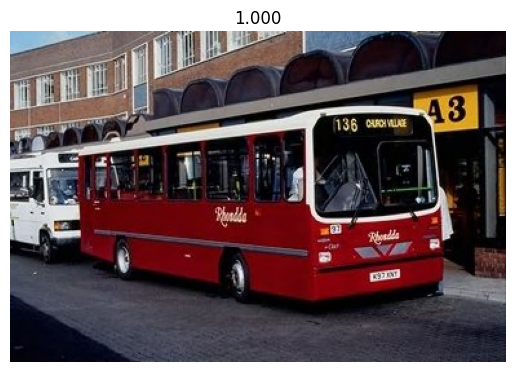

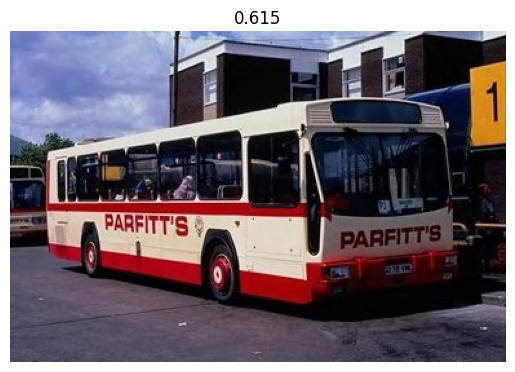

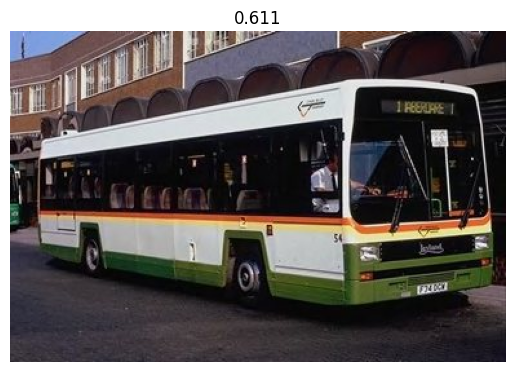

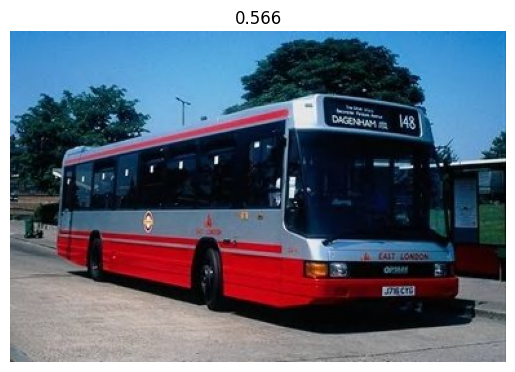

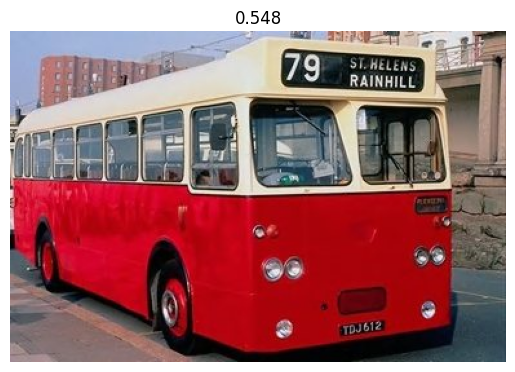

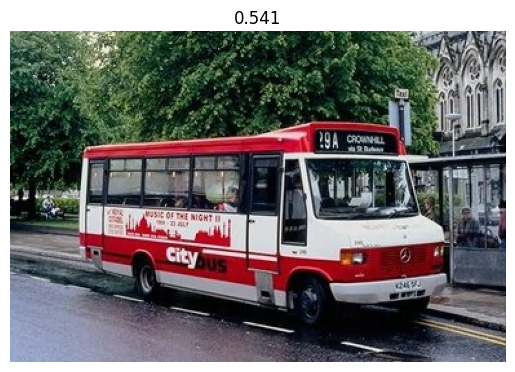

In [17]:
rootdir = '/content/corelImages/combined'
showSimilarImages(sorted_similarities, rootdir)

# VGG16 for brainTumor

In [18]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 136M/149M [00:01<00:00, 147MB/s]
100% 149M/149M [00:01<00:00, 126MB/s]


In [ ]:
!unzip '/content/brain-tumor-mri-dataset.zip' -d '/content/tumorDataset'

In [23]:
combineImages(['/content/tumorDataset/Training','/content/tumorDataset/Testing'], '/content/combinedTumor/')

Images have been successfully copied into a single folder. /content/combinedTumor/


1/1 [==============================] - 0s 493ms/step


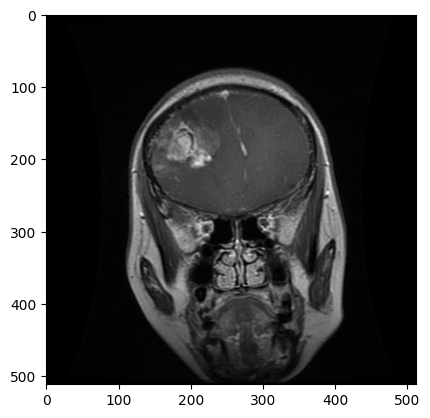

In [24]:
img = cv2.imread('/content/tumorDataset/Training/glioma/Tr-glTr_0000.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 'gray')
resized = cv2.resize(img, (224,224))
expanded = np.expand_dims(resized, 0)
feat = model.predict(expanded)

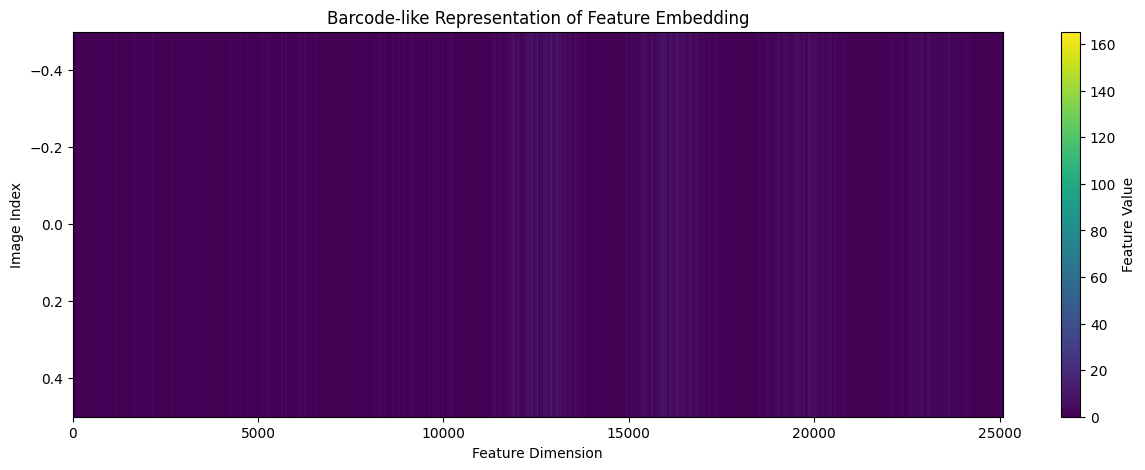

In [25]:
visualizeEmbeddings(feat)

In [26]:
deleteSomeImages('/content/combinedTumor', skipRate=10)

Images of multiple 10 indices have been successfully deleted from the directory.
Remaining Images: 702


In [27]:
image_dir = '/content/combinedTumor'
image_files = os.listdir(image_dir)

# Extract features for each image and store in a dictionary
features_dict = {}
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    features_dict[image_file] = extract_features(image_path, model)

1/1 [==============================] - 0s 499ms/step


In [28]:
query_image_path = '/content/tumorDataset/Testing/glioma/Te-glTr_0001.jpg'
query_features = extract_features(query_image_path, model)

1/1 [==============================] - 0s 484ms/step


In [29]:
similarities = {}
for image_file, features in features_dict.items():
    similarity = compute_similarity(query_features, features)
    similarities[image_file] = similarity

In [30]:
sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Display top N similar images
top_n = 5+1
for i in range(top_n):
    image_file, similarity = sorted_similarities[i]
    print(f"Similarity with {image_file}: {similarity}")

Similarity with Te-gl_0093.jpg: 0.6524851322174072
Similarity with Tr-pi_1065.jpg: 0.6277286410331726
Similarity with Tr-gl_0162.jpg: 0.6192106604576111
Similarity with Tr-me_0028.jpg: 0.6004519462585449
Similarity with Te-gl_0012.jpg: 0.5974510908126831
Similarity with Te-gl_0092.jpg: 0.5938736200332642


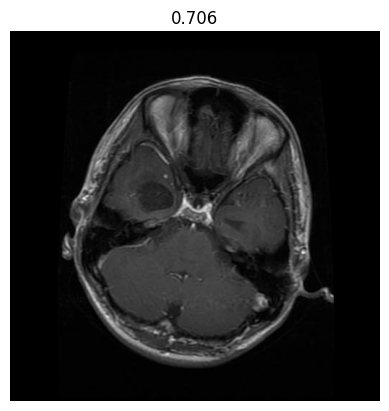

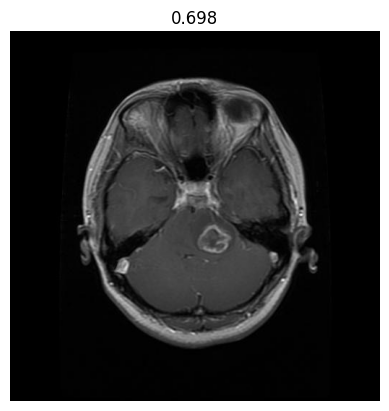

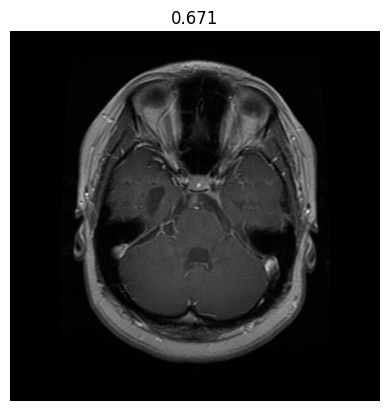

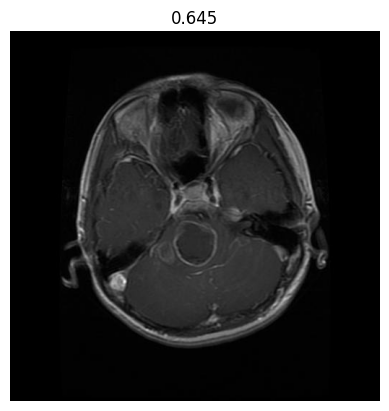

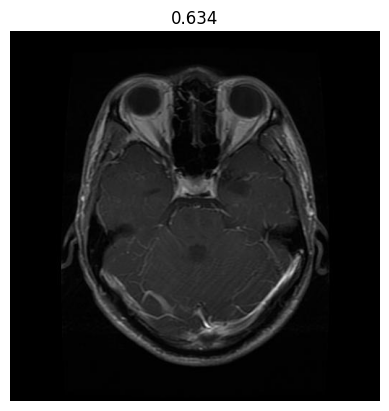

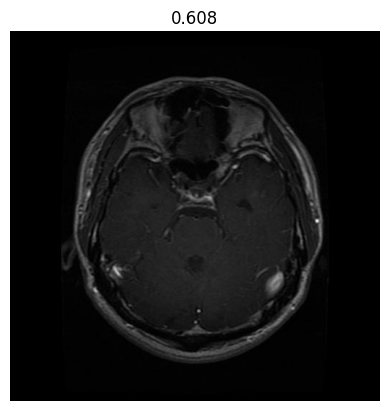

In [176]:
rootdir = '/content/combinedTumor/'
showSimilarImages(sorted_similarities, rootdir)

# VGG16 for another image

In [ ]:
# !gitclone https://github.com/sivaramakrishnan-rajaraman/contest-based-image-retrieval-using-transfer-learning.git

# Inception for Corel1K

In [31]:
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [32]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

1/1 [==============================] - 3s 3s/step


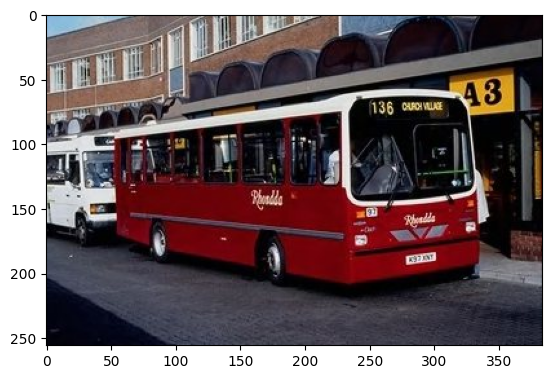

In [33]:
img = cv2.imread('/content/corelImages/combined/300.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 'gray')
resized = cv2.resize(img, (224,224))
expanded = np.expand_dims(resized, 0)
feat = model.predict(expanded)

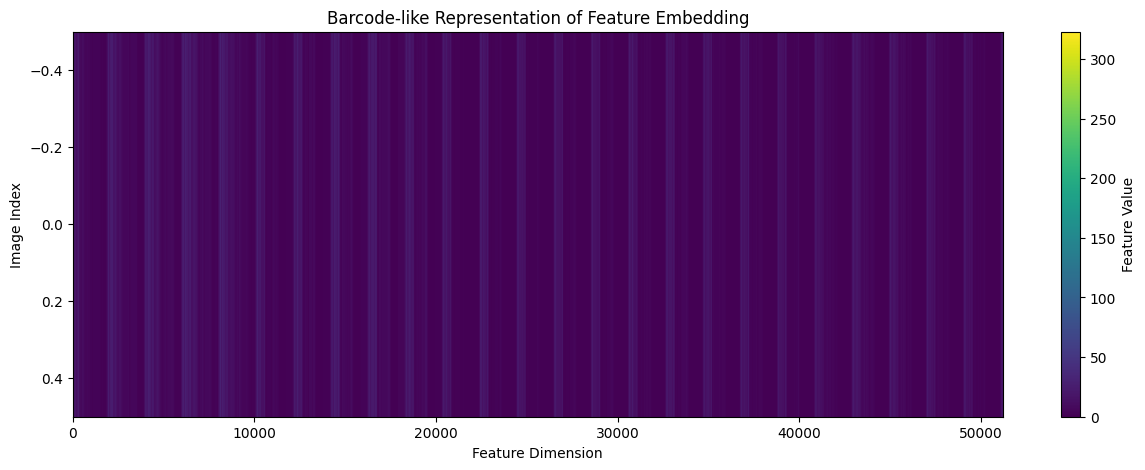

In [34]:
visualizeEmbeddings(feat)

In [186]:
image_dir = '/content/corelImages/combined'

# List of image file names
image_files = os.listdir(image_dir)

# Extract features for each image and store in a dictionary
features_dict = {}
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    features_dict[image_file] = extract_features(image_path, model)

1/1 [==============================] - 0s 127ms/step


In [188]:
query_image_path = '/content/corelImages/dataset/test_set/bus/300.jpg'
query_features = extract_features(query_image_path, model)

1/1 [==============================] - 0s 407ms/step


In [189]:
similarities = {}
for image_file, features in features_dict.items():
    similarity = compute_similarity(query_features, features)
    similarities[image_file] = similarity

In [190]:
sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Display top N similar images
top_n = 5+1
for i in range(top_n):
    image_file, similarity = sorted_similarities[i]
    print(f"Similarity with {image_file}: {similarity}")

Similarity with 300.jpg: 1.0
Similarity with 353.jpg: 0.700263261795044
Similarity with 323.jpg: 0.6790202260017395
Similarity with 62.jpg: 0.6788743734359741
Similarity with 315.jpg: 0.6708422899246216
Similarity with 327.jpg: 0.6664343476295471


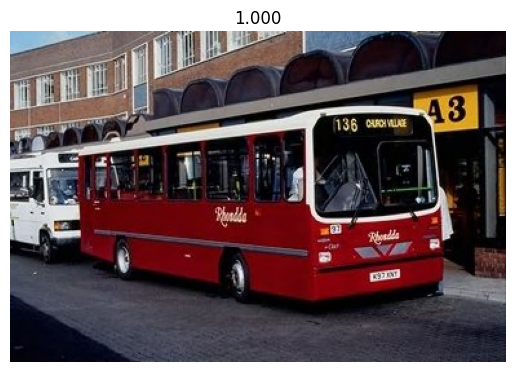

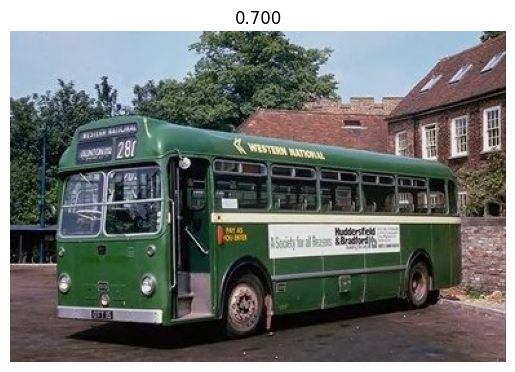

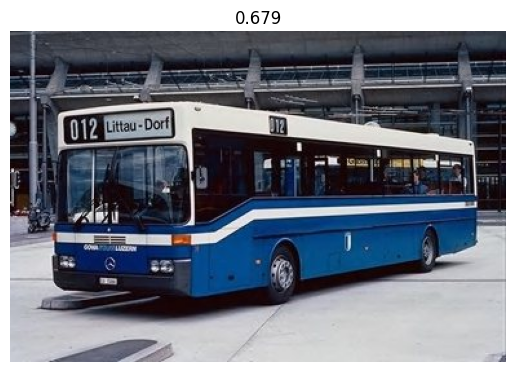

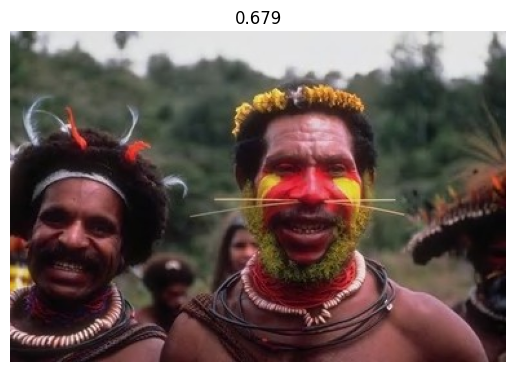

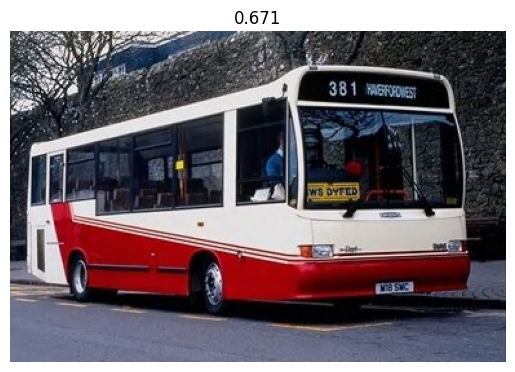

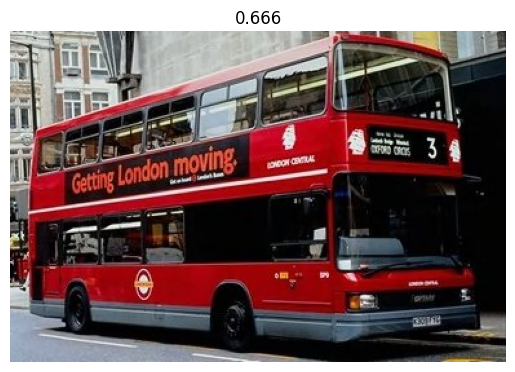

In [191]:
rootdir = '/content/corelImages/combined'
showSimilarImages(sorted_similarities, rootdir)

# Inception for Tumor

1/1 [==============================] - 0s 153ms/step


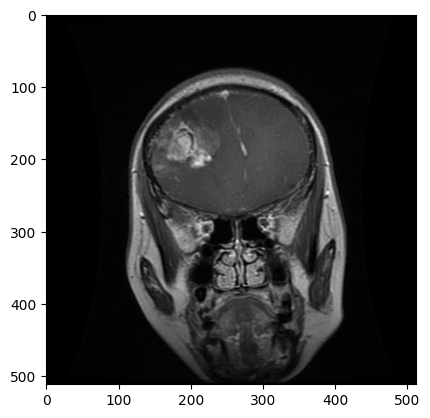

In [192]:
img = cv2.imread('/content/tumorDataset/Training/glioma/Tr-glTr_0000.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 'gray')
resized = cv2.resize(img, (224,224))
expanded = np.expand_dims(resized, 0)
feat = model.predict(expanded)

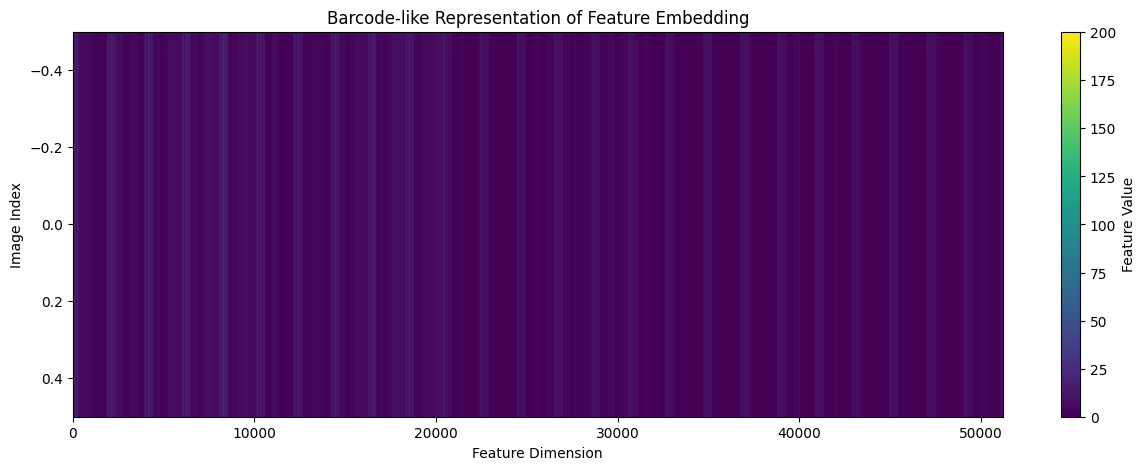

In [193]:
visualizeEmbeddings(feat)

# we have already reduced the images

In [ ]:
# deleteSomeImages('/content/combinedTumor', skipRate=7)

In [35]:
image_dir = '/content/combinedTumor'
image_files = os.listdir(image_dir)

# Extract features for each image and store in a dictionary
features_dict = {}
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    features_dict[image_file] = extract_features(image_path, model)

1/1 [==============================] - 0s 124ms/step


In [36]:
query_image_path = '/content/tumorDataset/Testing/glioma/Te-glTr_0001.jpg'
query_features = extract_features(query_image_path, model)

1/1 [==============================] - 0s 127ms/step


In [37]:
similarities = {}
for image_file, features in features_dict.items():
    similarity = compute_similarity(query_features, features)
    similarities[image_file] = similarity

In [38]:
sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Display top N similar images
top_n = 5+1
for i in range(top_n):
    image_file, similarity = sorted_similarities[i]
    print(f"Similarity with {image_file}: {similarity}")

Similarity with Tr-gl_0541.jpg: 0.8809085488319397
Similarity with Te-gl_0092.jpg: 0.8778928518295288
Similarity with Te-gl_0134.jpg: 0.8758785128593445
Similarity with Tr-pi_0167.jpg: 0.8536553382873535
Similarity with Tr-me_1319.jpg: 0.8499336838722229
Similarity with Tr-gl_0444.jpg: 0.8496861457824707


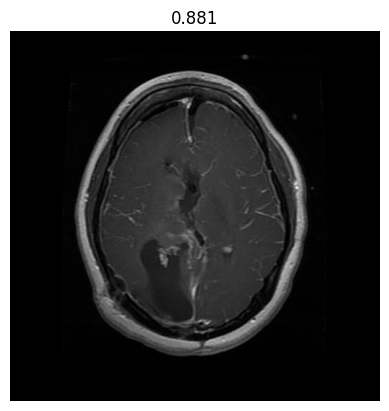

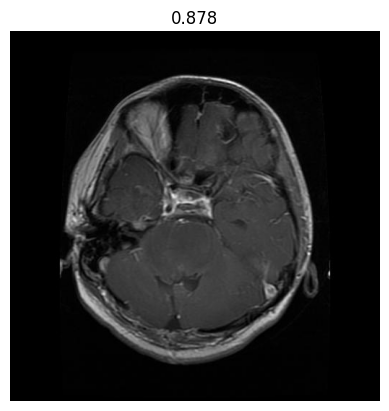

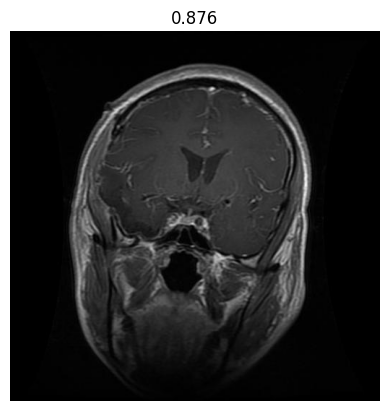

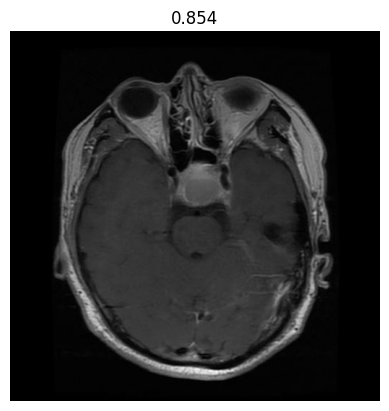

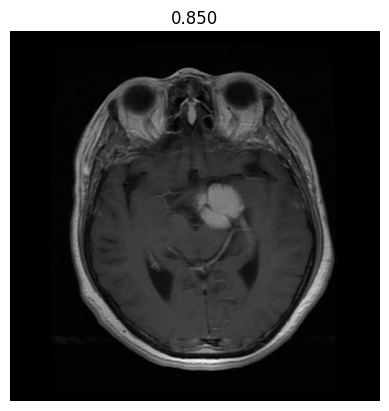

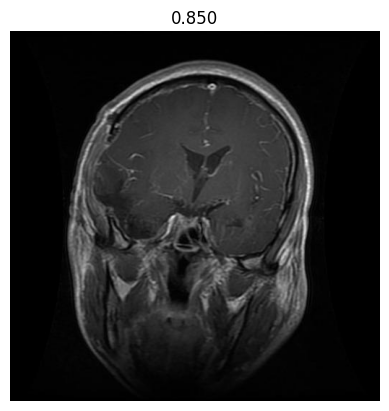

In [39]:
rootdir = '/content/combinedTumor/'
showSimilarImages(sorted_similarities, rootdir)